In [1]:
# Make sure that the path is the root of the project (it can be checked with '%pwd')

%cd ..

c:\Users\shrey\Desktop\DSC 214\DSC-241-Soccer-TDA


In [2]:
from pandas import json_normalize
from utils import read_json

In [3]:
lineups_path = "sample_data/lineups/{0}.json"
events_path = "sample_data/events/{0}.json"

team_name = "Barcelona"
match_id = 15946

### Step 1: Read data

In [4]:
lineups = read_json(lineups_path.format(match_id))
names_dict = {player["player_name"]: player["player_nickname"]
              for team in lineups for player in team["lineup"]}

names_dict

{'Malcom Filipe Silva de Oliveira': 'Malcom',
 'Philippe Coutinho Correia': 'Philippe Coutinho',
 'Sergio Busquets i Burgos': 'Sergio Busquets',
 'Jordi Alba Ramos': 'Jordi Alba',
 'Gerard Piqué Bernabéu': 'Gerard Piqué',
 'Luis Alberto Suárez Díaz': 'Luis Suárez',
 'Ivan Rakitić': None,
 'Ousmane Dembélé': None,
 'Samuel Yves Umtiti': 'Samuel Umtiti',
 'Lionel Andrés Messi Cuccittini': 'Lionel Messi',
 'Nélson Cabral Semedo': 'Nélson Semedo',
 'Sergi Roberto Carnicer': 'Sergi Roberto',
 'Clément Lenglet': None,
 'Rafael Alcântara do Nascimento': 'Rafinha',
 'Arturo Erasmo Vidal Pardo': 'Arturo Vidal',
 'Jasper Cillessen': None,
 'Arthur Henrique Ramos de Oliveira Melo': 'Arthur',
 'Marc-André ter Stegen': 'Marc-André ter Stegen',
 'Borja González Tomás': 'Borja Bastón',
 'Jonathan Rodríguez Menéndez': 'Jony',
 'Rubén Duarte Sánchez': 'Rubén Duarte',
 'Rubén Sobrino Pozuelo': 'Rubén Sobrino',
 'Víctor Laguardia Cisneros': 'Víctor Laguardia',
 'Ibai Gómez Pérez': 'Ibai Gómez',
 'Martín 

In [5]:
events = read_json(events_path.format(match_id))
df_events = json_normalize(events, sep="_").assign(match_id=match_id)

df_events.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,foul_committed_advantage,foul_won_advantage,clearance_aerial_won,pass_deflected,pass_no_touch,foul_committed_type_id,foul_committed_type_name,pass_straight,pass_goal_assist,match_id
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
1,0300039d-150d-41e4-b29a-76602ef002e6,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
2,491e8901-7630-4cc8-b57b-937dddff2eaa,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
3,757b85ad-ddfe-44d5-b893-c23a9fb709d8,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
4,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,5,1,00:00:00.575,0,0,2,2.015669,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946


### Step 2: Compute max. minutes

In [6]:
first_red_card_minute = df_events[df_events.foul_committed_card_name.isin(["Second Yellow", "Red Card"])].minute.min()
first_substitution_minute = df_events[df_events.type_name == "Substitution"].minute.min()
max_minute = df_events.minute.max()

num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)
num_minutes

45

### Step 3: Set text information

In [7]:
plot_name = "statsbomb_match{0}_{1}".format(match_id, team_name)

opponent_team = [x for x in df_events.team_name.unique() if x != team_name][0]
plot_title ="{0}'s passing network against {1} (StatsBomb eventing data)".format(team_name, opponent_team)

plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

### Step 4: Prepare data

In [8]:
def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0] / max_width, 1-(location[1] / max_height)

In [9]:
df_passes = df_events[(df_events.type_name == "Pass") &
                      (df_events.pass_outcome_name.isna()) &
                      (df_events.team_name == team_name) &
                      (df_events.minute < num_minutes)].copy()

# If available, use player's nickname instead of full name to optimize space in plot
df_passes["pass_recipient_name"] = df_passes.pass_recipient_name.apply(lambda x: names_dict[x] if names_dict[x] else x)
df_passes["player_name"] = df_passes.player_name.apply(lambda x: names_dict[x] if names_dict[x] else x)

df_passes.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,foul_committed_advantage,foul_won_advantage,clearance_aerial_won,pass_deflected,pass_no_touch,foul_committed_type_id,foul_committed_type_name,pass_straight,pass_goal_assist,match_id
10,be27cc25-92b5-4696-b43c-aad957a6119a,11,1,00:00:07.152,0,7,3,1.696529,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
12,b33c0b7f-7456-4efe-b43c-5fd7cbd14689,13,1,00:00:08.848,0,8,3,1.135950,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
15,c587e5ce-fe6e-4cfb-b510-8a8e193699d3,16,1,00:00:10.873,0,10,3,0.757764,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
23,d0c8ba85-0f6a-4e32-a6e4-75c18baf3fe3,24,1,00:00:30.460,0,30,3,1.301344,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946
26,a9a9f660-c4cf-4c52-9db5-20aef776fbfa,27,1,00:00:35.161,0,35,3,1.257452,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15946


In [10]:
df_passes["origin_pos_x"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[0])
df_passes["origin_pos_y"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[1])
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "median", "origin_pos_y": "median"})

player_position

,origin_pos_x,origin_pos_y
player_name,,
Gerard Piqué,0.490000,0.335000
Ivan Rakitić,0.585833,0.766250
Jordi Alba,0.662500,0.933750
Lionel Messi,0.667083,0.318750
Luis Suárez,0.755000,0.645000
Marc-André ter Stegen,0.105833,0.506250
Nélson Semedo,0.590833,0.115000
Ousmane Dembélé,0.726667,0.806250
Samuel Umtiti,0.467500,0.723125


In [11]:
player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value")

player_pass_count

,num_passes
player_name,
Gerard Piqué,44
Ivan Rakitić,72
Jordi Alba,59
Lionel Messi,30
Luis Suárez,14
Marc-André ter Stegen,11
Nélson Semedo,31
Ousmane Dembélé,33
Samuel Umtiti,30


In [12]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

pair_pass_count.head(10)

,num_passes
pair_key,
Gerard Piqué_Ivan Rakitić,18
Gerard Piqué_Jordi Alba,6
Gerard Piqué_Lionel Messi,4
Gerard Piqué_Luis Suárez,2
Gerard Piqué_Marc-André ter Stegen,7
Gerard Piqué_Nélson Semedo,13
Gerard Piqué_Ousmane Dembélé,1
Gerard Piqué_Samuel Umtiti,13
Gerard Piqué_Sergi Roberto,9


### Step 5: Plot passing network

c:\Users\shrey\Desktop\DSC 214\DSC-241-Soccer-TDA\visualization\passing_network.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
c:\Users\shrey\Desktop\DSC 214\DSC-241-Soccer-TDA\visualization\passing_network.py:112: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
c:\Users\shrey\Desktop\DSC 214\DSC-241-Soccer-TDA\visualization\passing_network.py:186: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "w-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([player1_x, player2_x], [player1_y, player2_y],
c:\Users\shrey\Desktop\DSC 214\DSC-2

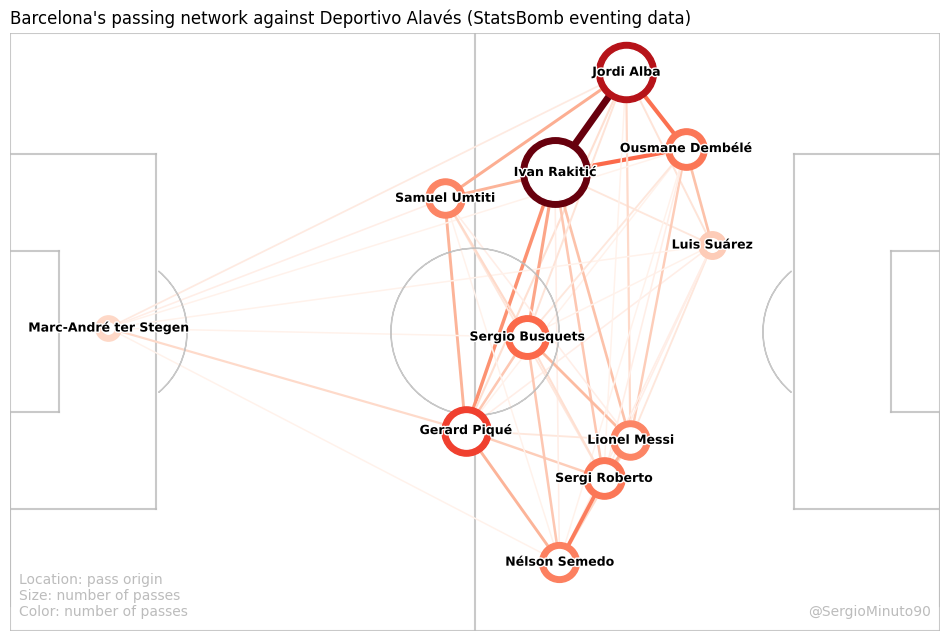

In [13]:
from visualization.passing_network import draw_pitch, draw_pass_map
import matplotlib.pyplot as plt


ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

plt.savefig("demo/{0}.png".format(plot_name))